In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ssid import markov, realize
from control.matlab import ss
from control.matlab import lsim
from control.matlab import impulse as _impulse
def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t

# Intro to System ID

### SDOF Parameters
    m = mass
    k = stiffness
    c = damping coefficient
    nt = # of timesteps
    dt = timestep

![sdof](./figures/sdof.png)

In [2]:
# parameters of SDOF system
m = 1           # mass
k = 100         # stiffness
zeta = 0.01     # damping ratio
omega_n = np.sqrt(k/m)  # natural frequency (rad/s)
c = 2*zeta*m*omega_n    # damping coefficient

# forcing frequencies (rad/s)
omega_f = [0.017*omega_n, 0.14*omega_n, 0.74*omega_n]

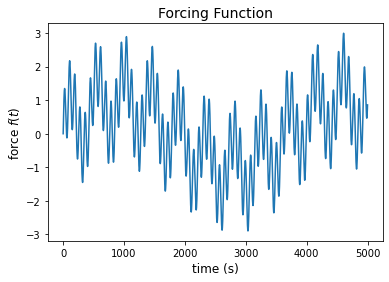

In [3]:
# forcing function
nt = 5000       # number of timesteps
dt = 0.01       # timestep
tf = nt*dt      # final time
t = np.arange(start = 0, stop = tf, step = dt)
f = np.sum(np.sin([omega*t for omega in omega_f]), axis=0)
plt.plot(f)
plt.xlabel("time (s)", fontsize=12)
plt.ylabel(r"force $f(t)$", fontsize=12)
plt.title("Forcing Function", fontsize=14);

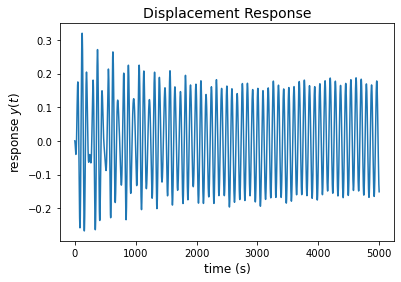

In [4]:
# displacement response (analytical solution)
omega_D = omega_n*np.sqrt(1-zeta**2)
y = np.zeros((3,nt))
for i,omega in enumerate(omega_f):
    C3 = (1/k)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C4 = -(2*zeta*omega/omega_n)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C1 = -C4
    C2 = (zeta*omega_n*C1-omega*C3)/omega_D
    y[i,:] = np.exp(-zeta*omega_n*t)*(C1*np.cos(omega_D*t)+C2*np.sin(omega_D*t)) + C3*np.sin(omega*t) + C4*np.cos(omega*t)
y = np.sum(y,axis=0)
plt.plot(y)
plt.xlabel("time (s)", fontsize=12)
plt.ylabel(r"response $y(t)$", fontsize=12)
plt.title("Displacement Response", fontsize=14);

# System Identification

### General Parameters
    p = # of output channels
    q = # of input channels
    nt = # of timesteps
    dt = timestep

### Specific to OKID
    m = # of Markov parameters to compute (at most = nt)

### Specific to ERA
    no = # of observability parameters
    nc = # of controllability parameters
    r = reduced model order

### Specific to DC
    a = (alpha) # of additional block rows in Hankel matrix of correlation matrices
    b = (beta) # of additional block columns in Hankel matrix of correlation matrices
    l = initial lag
    g = lag (gap) between correlations

In [102]:
p = 1
q = 1
m = 900
no = 400
nc = 400
r = 20
a = 0
b = 0
l = 10
g = 3

In [92]:
# ERA

r_era = 50
A,B,C,D = realize.era(y[None, None, :], no, nc, r=r_era)
y_era, times = impulse(ss(A,B,C,D,dt), t, input=0)

In [103]:
# ERA-DC

r_era_dc = 50
A,B,C,D = realize.era_dc(y[None, None, :], no, nc, a, b, l, g, r=r_era_dc)
y_era_dc, times = impulse(ss(A,B,C,D,dt), t, input=0)

In [116]:
# OKID-ERA

r_okid_era = 10
Y = markov.okid(y, f, m)
A,B,C,D = realize.era(Y, no, nc, r=r_okid_era)
y_okid_era = lsim(ss(A,B,C,D,dt),f,t)[0]

In [117]:
# OKID-ERA-DC

r_okid_era_dc = 10
Y = markov.okid(y, f, m)
A,B,C,D = realize.era_dc(y[None, None, :], no, nc, a, b, l, g, r=r_era_dc)
y_okid_era_dc, times = impulse(ss(A,B,C,D,dt), t, input=0)
# y_okid_era_dc = lsim(ss(A,B,C,D,dt),f,t)[0]

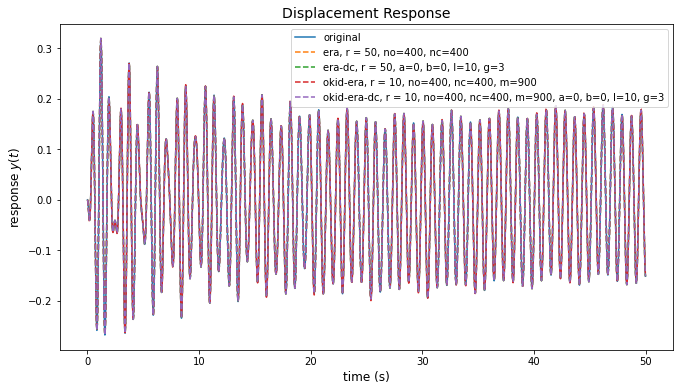

In [119]:
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(t,y,label="original")
ax.plot(t,y_era*dt,"--",label=f"era, r = {r_era}, {no=}, {nc=}")
ax.plot(t,y_era_dc*dt,"--",label=f"era-dc, r = {r_era_dc}, {a=}, {b=}, {l=}, {g=}")
ax.plot(t,y_okid_era,"--",label=f"okid-era, r = {r_okid_era}, {no=}, {nc=}, {m=}")
ax.plot(t,y_okid_era_dc*dt,"--",label=f"okid-era-dc, r = {r_okid_era_dc}, {no=}, {nc=}, {m=}, {a=}, {b=}, {l=}, {g=}")
ax.set_xlabel("time (s)", fontsize=12)
ax.set_ylabel(r"response $y(t)$", fontsize=12)
ax.set_title("Displacement Response", fontsize=14)
ax.legend();